In [1]:
import pandas as pd
from collections import Counter
import numpy as np
import math
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
%matplotlib inline
import matplotlib.pyplot as plt
!pip install dtreeviz
!pip install graphviz

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/justinchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
dataset = pd.read_csv('/Users/justinchen/Documents/mental_health_subreddits_dataset.csv')

In [50]:
sample = dataset.sample(1000)
sample.head()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
30070,13347733,depression,1597717785,I would hug you. Covid or not. While you may b...,0.9851
5971,3679305,covid19_support,1627157268,Thank you for the response! I did tell him tw...,0.4678
5739,3548686,anxiety,1627479763,Do you mean symptoms of illness by reactions? ...,0.9424
42085,16596785,suicidewatch,1587161799,"Ok, I know what it's like to have controlling ...",0.9981
41998,16571793,anxiety,1587248095,"Los Altos Hills, Calif.\nThe Covid-19 shutdown...",-0.0027


In [6]:
count = Counter()
for index, row in sample.iterrows():
    if row['subreddit.name'] == 'anxiety':
        count['anxiety'] += 1
    if row['subreddit.name'] == 'depression':
        count['depression'] += 1
    if row['subreddit.name'] == 'suicidewatch':
        count['SuicideWatch'] += 1
    if row['subreddit.name'] == 'mentalhealth':
        count['mentalhealth'] += 1
    if row['subreddit.name'] == 'covid19_support':
        count['COVID19_support'] += 1
count

Counter({'COVID19_support': 6940,
         'SuicideWatch': 1742,
         'anxiety': 7303,
         'mentalhealth': 1448,
         'depression': 2567})

## Preprocessing

In [7]:
import re #regex library used for substituting words

In [8]:
#removing stopwords and urls, stemming, making lowercase 
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def cleaning(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [9]:
def post_cleaning(text):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ',text)

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 
    
    #remove digits
    processed_feature = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", processed_feature)

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    return processed_feature

In [10]:
#above functions combined
def preprocessing(text):
    line = cleaning(text)
    line = post_cleaning (line)
    return line

In [51]:
sample.body = sample.body.apply(lambda x: preprocessing(x))

In [15]:
sample.head()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
10390,6030699,covid19_support,1619234152,really depends usa live things starting reopen...,negative
2141,1360365,covid19_support,1631713534,,neutral
8199,4921455,covid19_support,1622740319,definitely happened much decided live alone fr...,positive
6430,3987949,suicidewatch,1626344099,know feels like brother take wild guess must l...,positive
30891,13568918,anxiety,1597057022,post removed flagged see mentioned covid pleas...,positive


In [52]:
for sentiment in sample['sentiment']:
    if sentiment > 0:
        sample['sentiment'].replace({sentiment : 'positive'}, inplace=True)
    if sentiment < 0:
        sample['sentiment'].replace({sentiment : 'negative'}, inplace=True)
    else:
        sample['sentiment'].replace({sentiment : 'neutral'}, inplace=True)

Text(0.5, 1.0, 'Sentiment Data Distribution')

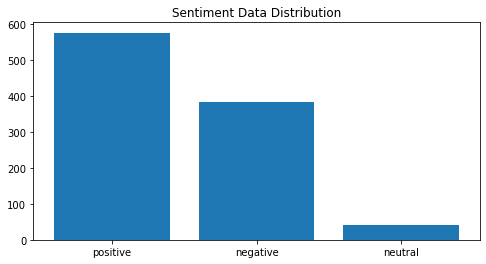

In [53]:
#Graphing
val_count = sample.sentiment.value_counts()
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [13]:
sample.head()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
43069,16933287,covid19_support,1586118631,little brother sick christmas week covid sympt...,negative
34885,14698214,depression,1593887677,yeah really bad covid social distancing enable...,negative
24591,11652122,suicidewatch,1603057097,dude death answer tried kill work understood w...,positive
24051,11480801,covid19_support,1603590027,hey thanks replies input greatly appreciated y...,positive
40029,16087761,anxiety,1588880060,big emily oster fan economist specializes pare...,positive


In [42]:
from sklearn.model_selection import train_test_split

In [54]:
 # Splits Dataset into Training and Testing set
train_size = 0.8
train_data, test_data = train_test_split(sample, test_size=1-train_size, random_state=42, shuffle=True)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 800
Test Data size 200


## Vectorizing

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [55]:
vectorizer = TfidfVectorizer(max_features=10000,
                             min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
vectorizer.fit(train_data.body.to_list())
x_train = vectorizer.transform(train_data.body.to_list())
x_test = vectorizer.transform(test_data.body.to_list())

In [56]:
print("x_train Shape:",x_train.shape)
print("x_test Shape:",x_test.shape)

x_train Shape: (800, 1341)
x_test Shape: (200, 1341)


In [22]:
from sklearn.preprocessing import LabelEncoder

In [57]:
encoder = LabelEncoder() #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (800, 1)
y_test shape: (200, 1)


## Random Forest Model

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
model = RandomForestClassifier()
model.fit(x_train, y_train.ravel())
predicted_labels = model.predict(x_test)
print ('Accuracy:', model.score(x_test, y_test))

Accuracy: 0.7


## Feature Importances

In [26]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.tree import export_graphviz

In [27]:
from sklearn.tree import export_text
for tree in model.estimators_:
    text_representation = export_text(tree, feature_names = vectorizer.get_feature_names())
    print(text_representation)

/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


|--- cancer <= 0.09
|   |--- dont <= 0.10
|   |   |--- like <= 0.12
|   |   |   |--- suicide <= 0.09
|   |   |   |   |--- coronavirus <= 0.17
|   |   |   |   |   |--- ask <= 0.07
|   |   |   |   |   |   |--- safe <= 0.04
|   |   |   |   |   |   |   |--- give <= 0.03
|   |   |   |   |   |   |   |   |--- great <= 0.03
|   |   |   |   |   |   |   |   |   |--- free <= 0.09
|   |   |   |   |   |   |   |   |   |   |--- attempts <= 0.03
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 388
|   |   |   |   |   |   |   |   |   |   |--- attempts >  0.03
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |   |--- free >  0.09
|   |   |   |   |   |   |   |   |   |   |--- whole <= 0.11
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 32
|   |   |   |   |   |   |   |   |   |   |--- whole >  0.11
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |


|--- better <= 0.05
|   |--- helps <= 0.06
|   |   |--- look <= 0.16
|   |   |   |--- dangerous <= 0.08
|   |   |   |   |--- anxiety <= 0.11
|   |   |   |   |   |--- risk <= 0.08
|   |   |   |   |   |   |--- suicidal <= 0.10
|   |   |   |   |   |   |   |--- positive <= 0.06
|   |   |   |   |   |   |   |   |--- hope <= 0.05
|   |   |   |   |   |   |   |   |   |--- anxiety <= 0.03
|   |   |   |   |   |   |   |   |   |   |--- sorry <= 0.24
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 376
|   |   |   |   |   |   |   |   |   |   |--- sorry >  0.24
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 15
|   |   |   |   |   |   |   |   |   |--- anxiety >  0.03
|   |   |   |   |   |   |   |   |   |   |--- free <= 0.09
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 77
|   |   |   |   |   |   |   |   |   |   |--- free >  0.09
|   |   |   |   |   |   |   |   |   |   |   |--- class: 2.0
|   |   |   |   |   |   |   |  


|--- point <= 0.09
|   |--- pain <= 0.14
|   |   |--- really <= 0.04
|   |   |   |--- sucks <= 0.10
|   |   |   |   |--- positive <= 0.15
|   |   |   |   |   |--- almost <= 0.04
|   |   |   |   |   |   |--- unrelated <= 0.02
|   |   |   |   |   |   |   |--- become <= 0.08
|   |   |   |   |   |   |   |   |--- parents <= 0.22
|   |   |   |   |   |   |   |   |   |--- please <= 0.16
|   |   |   |   |   |   |   |   |   |   |--- homeless <= 0.11
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 363
|   |   |   |   |   |   |   |   |   |   |--- homeless >  0.11
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |   |--- please >  0.16
|   |   |   |   |   |   |   |   |   |   |--- anti <= 0.13
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 13
|   |   |   |   |   |   |   |   |   |   |--- anti >  0.13
|   |   |   |   |   |   |   |   |   |   |   |--- class: 2.0
|   |   |   |   |   |   |  


|--- support <= 0.07
|   |--- depressed <= 0.12
|   |   |--- mum <= 0.18
|   |   |   |--- abusive <= 0.06
|   |   |   |   |--- removed <= 0.20
|   |   |   |   |   |--- could <= 0.30
|   |   |   |   |   |   |--- things <= 0.04
|   |   |   |   |   |   |   |--- terrified <= 0.12
|   |   |   |   |   |   |   |   |--- action <= 0.13
|   |   |   |   |   |   |   |   |   |--- great <= 0.08
|   |   |   |   |   |   |   |   |   |   |--- exercise <= 0.09
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 389
|   |   |   |   |   |   |   |   |   |   |--- exercise >  0.09
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 24
|   |   |   |   |   |   |   |   |   |--- great >  0.08
|   |   |   |   |   |   |   |   |   |   |--- minor <= 0.16
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 30
|   |   |   |   |   |   |   |   |   |   |--- minor >  0.16
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |  

|--- compose <= 0.09
|   |--- sick <= 0.08
|   |   |--- focus <= 0.05
|   |   |   |--- helpful <= 0.02
|   |   |   |   |--- dad <= 0.07
|   |   |   |   |   |--- tips <= 0.12
|   |   |   |   |   |   |--- shit <= 0.05
|   |   |   |   |   |   |   |--- grateful <= 0.10
|   |   |   |   |   |   |   |   |--- hear <= 0.06
|   |   |   |   |   |   |   |   |   |--- keep <= 0.04
|   |   |   |   |   |   |   |   |   |   |--- look <= 0.02
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 352
|   |   |   |   |   |   |   |   |   |   |--- look >  0.02
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 66
|   |   |   |   |   |   |   |   |   |--- keep >  0.04
|   |   |   |   |   |   |   |   |   |   |--- due <= 0.13
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 82
|   |   |   |   |   |   |   |   |   |   |--- due >  0.13
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |-

|--- see <= 0.15
|   |--- hell <= 0.11
|   |   |--- discussion <= 0.12
|   |   |   |--- luck <= 0.05
|   |   |   |   |--- rate <= 0.11
|   |   |   |   |   |--- interested <= 0.03
|   |   |   |   |   |   |--- horrible <= 0.12
|   |   |   |   |   |   |   |--- suicide <= 0.11
|   |   |   |   |   |   |   |   |--- spanish <= 0.03
|   |   |   |   |   |   |   |   |   |--- blaming <= 0.06
|   |   |   |   |   |   |   |   |   |   |--- look <= 0.02
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 370
|   |   |   |   |   |   |   |   |   |   |--- look >  0.02
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 95
|   |   |   |   |   |   |   |   |   |--- blaming >  0.06
|   |   |   |   |   |   |   |   |   |   |--- breaks <= 0.04
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |   |   |   |   |   |   |   |--- breaks >  0.04
|   |   |   |   |   |   |   |   |   |   |   |--- class: 2.0
|   |   |   |   |   |   |   |


|--- anxiety <= 0.14
|   |--- helps <= 0.01
|   |   |--- get <= 0.03
|   |   |   |--- causing <= 0.13
|   |   |   |   |--- fear <= 0.05
|   |   |   |   |   |--- decline <= 0.04
|   |   |   |   |   |   |--- barely <= 0.08
|   |   |   |   |   |   |   |--- death <= 0.09
|   |   |   |   |   |   |   |   |--- attempts <= 0.10
|   |   |   |   |   |   |   |   |   |--- well <= 0.03
|   |   |   |   |   |   |   |   |   |   |--- thanks <= 0.17
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 382
|   |   |   |   |   |   |   |   |   |   |--- thanks >  0.17
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 12
|   |   |   |   |   |   |   |   |   |--- well >  0.03
|   |   |   |   |   |   |   |   |   |   |--- depressed <= 0.13
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 102
|   |   |   |   |   |   |   |   |   |   |--- depressed >  0.13
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   | 

In [63]:
fig = plt.figure(figsize=(25,20))
for tree in model.estimators_:
    tree.plot_tree(tree, 
                  feature_names=vectorizer.get_feature_names(),  
                  class_names=['negative', 'neutral', 'positive'],
                   filled=True)

AttributeError: 'DecisionTreeClassifier' object has no attribute 'plot_tree'

<Figure size 1800x1440 with 0 Axes>

In [30]:
from dtreeviz.trees import dtreeviz # remember to load the package

for tree in model.estimators_:
    viz = dtreeviz(tree, x_train, y_train,
                   target_name="target",
                   feature_names=vectorizer.get_feature_names(),
                   class_names=['negative', 'neutral', 'positive'])

viz

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all().

In [59]:
import graphviz
# DOT data
for tree in model.estimators_:
    dot_data = export_graphviz(tree, out_file=None, 
                                feature_names=vectorizer.get_feature_names(),  
                                class_names=['negative', 'neutral', 'positive'],
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 

/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [61]:
graph.render("decision_tree_COVID")

'decision_tree_COVID.png'

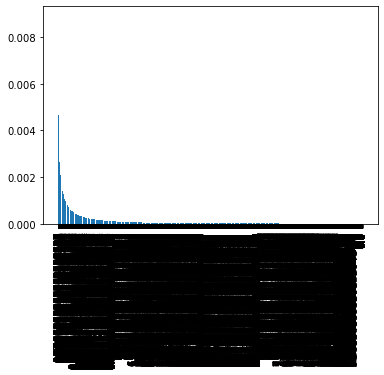

In [72]:
# Get feature importances from our random forest model
importances = model.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(importances)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()